In [1]:
%%capture
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import unicodedata
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud

In [9]:
df_raw = pd.read_csv('../data/raw/Big_AHR.csv')

In [10]:
df_positive = df_raw[df_raw['rating']>=4]

In [11]:
%%capture
!pip install keybert

In [12]:
from keybert import KeyBERT

In [13]:
kw_model = KeyBERT(model='all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [14]:
def normalize_str(text_string):
    if text_string is not None:
        result = unicodedata.normalize('NFD', text_string).encode('ascii', 'ignore').decode()
    else:
        result = None
    return result

In [15]:
def non_alphanumeric(texto):
    return re.sub("(\\W)+"," ", texto)

In [16]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
stop_words = stopwords.words('spanish')

for word in ['no', 'sin', 'nada']:
    stop_words.remove(word)

stop_words.append('hotel')

for i in range(len(stop_words)):
    stop_words[i] = normalize_str(stop_words[i])

In [18]:
def remove_stopwords(text_string):
    word_tokens = word_tokenize(text_string)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    sentence = ' '.join(str(x) for x in filtered_sentence)
    return sentence

In [19]:
title = df_positive['title'].tolist()
review = df_positive['review_text'].tolist()

In [20]:
def key_phrases(title, review):
    key_phrases = []
    for i in range(len(title)):
        text = remove_stopwords(non_alphanumeric(normalize_str((title[i] + ' ' + review[i]).lower())))
        keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 3), highlight=False, top_n=2)
        keywords_list= list(dict(keywords).keys())
        for keyword in keywords_list:
            key_phrases.append(keyword)
    return key_phrases

In [ ]:
df_key_phrases = key_phrases(title, review)

In [5]:
df_key_phrases.to_csv('../data/processed/positive_key_phrases.csv')

In [6]:
df_key_phrases = pd.read_csv('../data/processed/positive_key_phrases.csv')

In [20]:
df_key_phrases = df_key_phrases.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [10]:
tfile = open('positive_key_phrases.txt', 'a')
tfile.write(df_key_phrases['text'].to_string())
tfile.close()

In [11]:
model = fasttext.train_unsupervised('positive_key_phrases.txt')

Read 0M words
Number of words:  1822
Number of labels: 0
Progress: 100.0% words/sec/thread:  143175 lr:  0.000000 avg.loss:  2.972328 ETA:   0h 0m 0s


In [12]:
df_key_phrases['vec'] = df_key_phrases['text'].apply(lambda x: model.get_sentence_vector(str(x)))

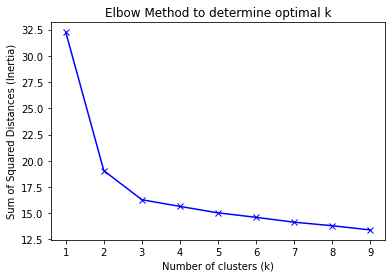

In [13]:
sum_squared_distances = []

K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_key_phrases['vec'].values.tolist())
    sum_squared_distances.append(kmeans.inertia_)

plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method to determine optimal k')
plt.show()

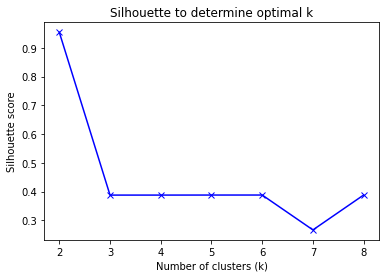

In [14]:
n_clusters_range = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in n_clusters_range:

    # fit Kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_key_phrases['vec'].values.tolist())
    cluster_labels = kmeans.labels_

    # calculate silhouette
    silhouette_avg.append(silhouette_score(df_key_phrases['vec'].values.tolist(), cluster_labels))

plt.plot(n_clusters_range, silhouette_avg, 'bx-')    
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette to determine optimal k')
plt.show()

In [15]:
kmeans = KMeans(n_clusters=2)

In [22]:
df_key_phrases['cluster'] = kmeans.fit_predict(df_key_phrases['vec'].values.tolist())

In [23]:
cluster_0 = df_key_phrases[df_key_phrases['cluster']==0]
cluster_1 = df_key_phrases[df_key_phrases['cluster']==1]

In [25]:
cluster_0.sample(5)

text  \
23316   necesario planeamos llevar   
23068  buena albergue recomendable   
23450         facil acceso granada   
5272           conocer ciudad tina   
11876          mucha parte granada   

                                                     vec  cluster  
23316  [-0.056064405, 0.21345365, -0.090851694, -0.00...        0  
23068  [-0.05515827, 0.21460268, -0.09463691, -0.0122...        0  
23450  [-0.054156154, 0.21203157, -0.09217989, -0.010...        0  
5272   [-0.05508749, 0.21251321, -0.09295386, -0.0123...        0  
11876  [-0.05466042, 0.21249865, -0.0930278, -0.01152...        0

In [30]:
cluster_1.sample(5)

text  \
16900  cordoba omgeving zijn   
4054        estilo visco lcd   
18200   habitacion aseada wc   
998        duda alfonso xiii   
18220      cordoba 3th floor   

                                                     vec  cluster  
16900  [-0.035149217, 0.19672088, -0.03895259, -0.026...        1  
4054   [-0.02409227, 0.15527779, -0.04267282, 0.01913...        1  
18200  [-0.022522395, 0.11251736, -0.04833953, 0.0039...        1  
998    [-0.07229033, 0.12402202, -0.06609962, -0.0177...        1  
18220  [-0.033787362, 0.16747648, -0.01566681, 0.0267...        1

In [33]:
def generate_wordcloud(df):
    text = ' '.join([str(i) for i in df['text']])
    wordcloud = WordCloud(max_words=100, background_color='Black').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

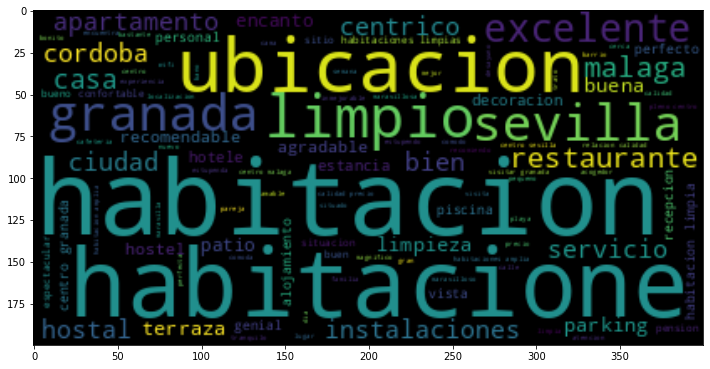

In [34]:
generate_wordcloud(cluster_0)

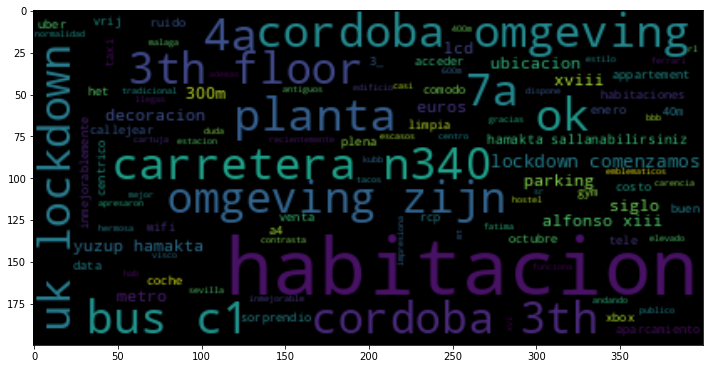

In [35]:
generate_wordcloud(cluster_1)

In [36]:
len(cluster_0)

26336

In [37]:
len(cluster_1)

110

In [38]:
# Main components to make 3D plot

pca = PCA(n_components=3)
df_key_phrases['x'] = pca.fit_transform(df_key_phrases['vec'].values.tolist())[:,0]
df_key_phrases['y'] = pca.fit_transform(df_key_phrases['vec'].values.tolist())[:,1]
df_key_phrases['z'] = pca.fit_transform(df_key_phrases['vec'].values.tolist())[:,2]

In [39]:
df_key_phrases['cluster'] = df_key_phrases['cluster'].astype('category')

In [40]:
fig = px.scatter_3d(df_key_phrases, x='x', y='y', z='z', color='cluster')
fig.update_traces(marker_size = 2)
fig.show()